## Spatial Simulation

In [474]:
import pandas as pd
import numpy as np
import scanpy as sc
import networkx as nx
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import importlib
import random
from joblib import Parallel, delayed
random.seed(123)

## Visium DLPFC data

We downloaded the manual annotation from the spatialLIBD package and provided at

https://drive.google.com/drive/folders/10lhz5VY7YfvHrtV40MwaqLmWz56U9eBP?usp=sharing.

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [15]:
section_id = '151676'
parent_dir = '/n/fs/ragr-data/datasets/spatial_transcriptomics/DLPFC_data'
adata = sc.read_h5ad(os.path.join(parent_dir, section_id + ".h5ad"))


In [16]:
adata

AnnData object with n_obs × n_vars = 3460 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'sce.sample_name', 'sce.layer_guess'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial', 'spatial_neighbors', 'transforms'
    obsm: 'spatial'
    obsp: 'spatial_connectivities', 'spatial_distances'

In [17]:
true_df = pd.read_csv(os.path.join(parent_dir, 'DLPFC_annotations' , section_id+'_truth.txt'), sep='\t', header=None, index_col=0)
true_df.columns = ['Ground Truth']

In [18]:
adata.obs['Ground_Truth'] = true_df.loc[adata.obs_names, 'Ground Truth']

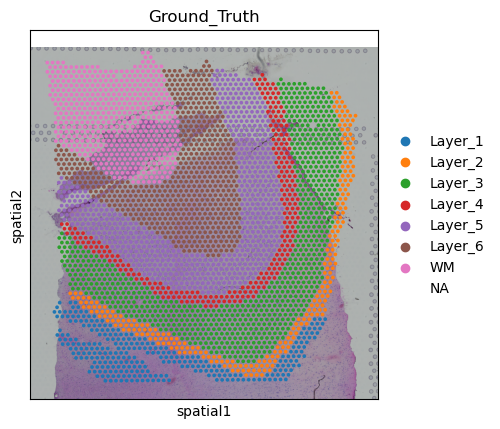

In [19]:
#plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.spatial(adata, img_key="hires", color=["Ground_Truth"])

## Construct boundaries

In [20]:
sys.path.append("/n/fs/ragr-research/users/hirak/Projects/copulacci/src/copulacci/")
import cci
import spatial
import model

In [21]:
importlib.reload(spatial)

<module 'spatial' from '/n/fs/ragr-research/users/hirak/Projects/copulacci/src/copulacci/spatial.py'>

In [22]:
int_edges, int_edges_with_loops = spatial.construct_boundary(adata, domanin_name='Ground_Truth')

relabeling nodes


In [24]:
int_edges.head()

,cell1,cell2,celltype1,celltype2,boundary_type,interaction
0,AAACAATCTACTAGCA-1,ATAAACCATTGGACGG-1,Layer_1,Layer_1,Internal,Layer_1=Layer_1
1,ATAAACCATTGGACGG-1,AAACAATCTACTAGCA-1,Layer_1,Layer_1,Internal,Layer_1=Layer_1
2,AAACAATCTACTAGCA-1,CGCTACCGCCCTATGA-1,Layer_1,Layer_1,Internal,Layer_1=Layer_1
3,CGCTACCGCCCTATGA-1,AAACAATCTACTAGCA-1,Layer_1,Layer_1,Internal,Layer_1=Layer_1
4,AAACAATCTACTAGCA-1,CTAAACGGGTGTAATC-1,Layer_1,Layer_1,Internal,Layer_1=Layer_1


## Take the layer 2, layer 4 and layer 1 edges and for simulation 

In [25]:
layer_2_df = int_edges.loc[
    (int_edges.celltype2 == 'Layer_2') |
    (int_edges.celltype1 == 'Layer_2')
]

In [26]:
layer_2_df.head()

,cell1,cell2,celltype1,celltype2,boundary_type,interaction
418,AACATCGATACGTCTA-1,AGGCGTCTATGGACGG-1,Layer_2,Layer_2,Internal,Layer_2=Layer_2
419,AGGCGTCTATGGACGG-1,AACATCGATACGTCTA-1,Layer_2,Layer_2,Internal,Layer_2=Layer_2
420,AACATCGATACGTCTA-1,CCGAGCTGTGCTTGTC-1,Layer_2,Layer_2,Internal,Layer_2=Layer_2
421,CCGAGCTGTGCTTGTC-1,AACATCGATACGTCTA-1,Layer_2,Layer_2,Internal,Layer_2=Layer_2
422,AACATCGATACGTCTA-1,CCGTATTAGCGCAGTT-1,Layer_2,Layer_2,Internal,Layer_2=Layer_2


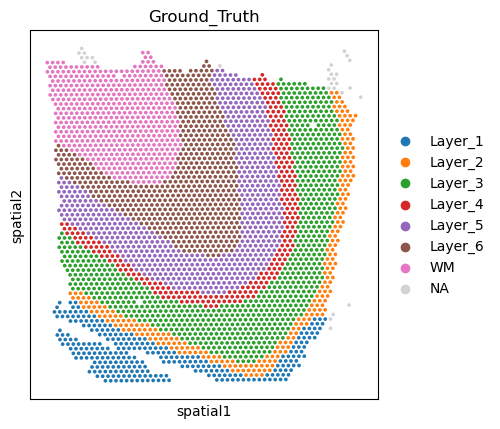

In [27]:
sc.pl.spatial(adata, color='Ground_Truth', img_key=None)

In [165]:
loc = adata.obsm['spatial']

loc_df = pd.DataFrame(loc).rename(columns = {0:"x", 1:"y"})
loc_df.loc[:,"cell"] = adata.obs_names

In [166]:
loc_df.loc[:,'x'] = loc_df.x - loc_df.x.min()
loc_df.loc[:,'y'] = loc_df.y - loc_df.y.min()

In [167]:
_pivoted_df =  pd.concat( [layer_2_df[["cell1","interaction"]].rename(columns = {"cell1": "cell"}), 
                layer_2_df[["cell2","interaction"]].rename(columns = {"cell2": "cell"}) 
            ], 
            axis = 0, ignore_index=True)

In [168]:
int_loc_df = pd.merge(_pivoted_df, loc_df, on="cell")

In [169]:
int_loc_df.drop_duplicates(['cell'], inplace = True)

In [170]:
loc_df.set_index('cell', inplace = True)

In [171]:
int_loc_df.set_index('cell', inplace=True)

In [172]:
G = adata.uns["spatial_network_names"]

In [173]:
G2 = nx.induced_subgraph(G, int_loc_df.index)

In [174]:
print(G2)

Graph with 417 nodes and 997 edges


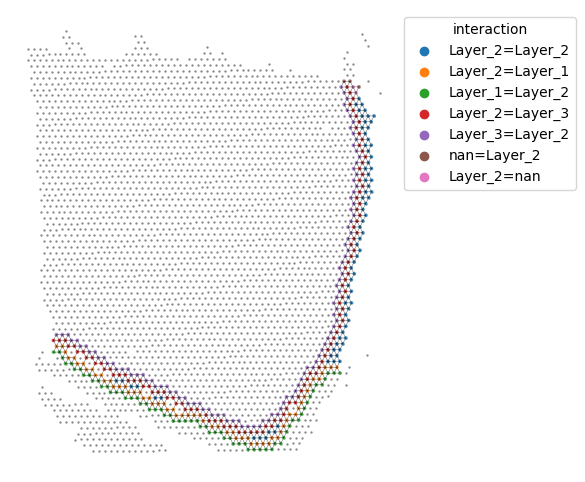

In [175]:
fig, ax = plt.subplots(figsize=(5,6))
ax.scatter(loc_df['x'], loc_df['y'], c= "grey", s=0.4)
sns.scatterplot(data = int_loc_df, x = "x", y = "y", hue = "interaction", s = 8, ax=ax, alpha=0.8)
for edge in G2.edges():
    x1, y1 = loc_df.loc[ edge[0], 'x' ], loc_df.loc[ edge[0], 'y' ]
    x2, y2 = loc_df.loc[ edge[1], 'x' ], loc_df.loc[ edge[1], 'y' ]
    ax.plot([x1, x2], [y1, y2], color='black',linewidth = 0.2)
plt.gca().invert_yaxis()
plt.axis('off')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [176]:
max_matches = nx.maximal_matching(G2)

In [177]:
start_nodes = list(map(lambda x : x[0], max_matches))
end_nodes = list(map(lambda x : x[1], max_matches))

In [178]:

start_nodes = int_loc_df.loc[start_nodes]
end_nodes = int_loc_df.loc[end_nodes]

In [179]:
int_loc_df['dist_from_z'] = int_loc_df.x ** 2 + int_loc_df.y ** 2

In [ ]:
[6000, 0]
[6000, 6000]

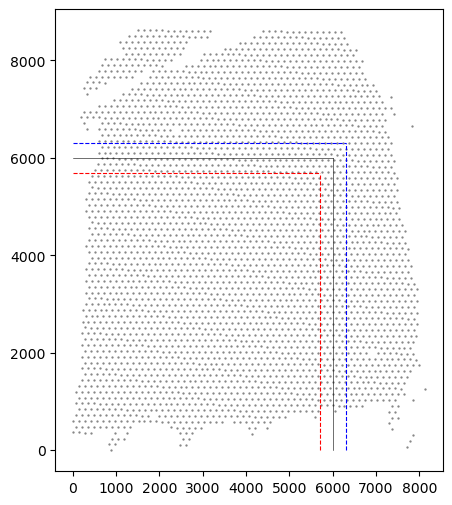

In [215]:
fig, ax = plt.subplots(figsize=(5,6))
diag_point = np.array([6000, 6000])
diag_point_pos = diag_point + 300
diag_point_neg = diag_point - 300
ax.scatter(loc_df['x'], loc_df['y'], c= "grey", s=0.4)
#sns.scatterplot(data = int_loc_df, x = "x", y = "y", s = 8, hue='dist_from_z', ax=ax, alpha=0.8,label='start')
ax.plot([0, diag_point[0]], diag_point, color = 'black', linewidth=0.4)
ax.plot(diag_point, [0, diag_point[1]], color = 'black', linewidth=0.4)

ax.plot([0, diag_point_pos[0]], diag_point_pos, color = 'blue', linewidth=0.8, linestyle='dashed')
ax.plot(diag_point_pos, [0, diag_point_pos[1]], color = 'blue', linewidth=0.8, linestyle='dashed')

ax.plot([0, diag_point_neg[0]], diag_point_neg, color = 'red', linewidth=0.8, linestyle='dashed')
ax.plot(diag_point_neg, [0, diag_point_neg[1]], color = 'red', linewidth=0.8, linestyle='dashed')


#plt.axis('off')
#sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

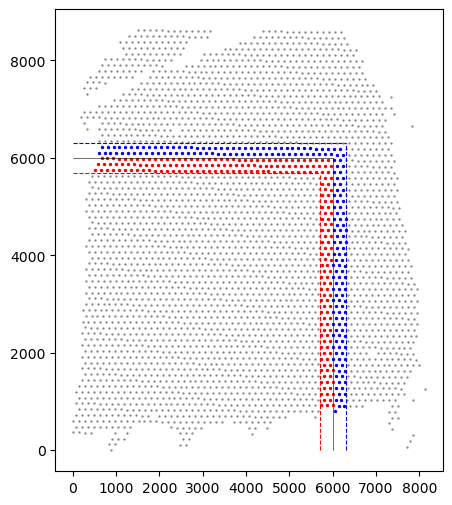

In [235]:
fig, ax = plt.subplots(figsize=(5,6))
diag_point = np.array([6000, 6000])
diag_point_pos = diag_point + 300
diag_point_neg = diag_point - 300
ax.scatter(loc_df['x'], loc_df['y'], c= "grey", s=0.4)
#sns.scatterplot(data = int_loc_df, x = "x", y = "y", s = 8, hue='dist_from_z', ax=ax, alpha=0.8,label='start')
ax.plot([0, diag_point[0]], diag_point, color = 'black', linewidth=0.4)
ax.plot(diag_point, [0, diag_point[1]], color = 'black', linewidth=0.4)

ax.plot([0, diag_point_pos[0]], diag_point_pos, color = 'blue', linewidth=0.8, linestyle='dashed')
ax.plot(diag_point_pos, [0, diag_point_pos[1]], color = 'blue', linewidth=0.8, linestyle='dashed')

ax.plot([0, diag_point_neg[0]], diag_point_neg, color = 'red', linewidth=0.8, linestyle='dashed')
ax.plot(diag_point_neg, [0, diag_point_neg[1]], color = 'red', linewidth=0.8, linestyle='dashed')


tmp_neg = loc_df.loc[
    ( (loc_df.x < diag_point[0]) & (loc_df.x > diag_point_neg[0]) & (loc_df.y < diag_point[1]) ) |
    ( (loc_df.y < diag_point[1]) & (loc_df.y > diag_point_neg[1]) & (loc_df.x < diag_point[0]) )
]

tmp_pos = loc_df.loc[
    ( (loc_df.x > diag_point[0]) & (loc_df.x < diag_point_pos[0]) & (loc_df.y < diag_point_pos[1]) ) |
    ( (loc_df.y > diag_point[1]) & (loc_df.y < diag_point_pos[1]) & (loc_df.x < diag_point_pos[0]) )
]

ax.scatter(tmp_neg['x'], tmp_neg['y'], c= "red", s=2)
ax.scatter(tmp_pos['x'], tmp_pos['y'], c= "blue", s=2);

In [236]:
tmp_neg.loc[:,'type_point'] = 'red'
tmp_pos.loc[:,'type_point'] = 'blue'
tmp_both = pd.concat([tmp_pos, tmp_neg], axis =0)

In [239]:
coords = tmp_both[['x', 'y']].values

In [271]:
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.neighbors import NearestNeighbors
from scipy.spatial import Delaunay
from scipy.sparse import csr_matrix
from itertools import chain
N = coords.shape[0]
n_neighs = 10
r = 1 if radius is None else radius if isinstance(radius, (int, float)) else max(radius)
tree = NearestNeighbors(n_neighbors=n_neighs, radius=600, metric="euclidean")
tree.fit(coords)
results = tree.radius_neighbors()
dists = np.concatenate(results[0])
row_indices = np.concatenate(results[1])
col_indices = np.repeat(np.arange(N), [len(x) for x in results[1]])
Adj = csr_matrix((np.ones_like(row_indices, dtype=np.float64), (row_indices, col_indices)), shape=(N, N))
Dst = csr_matrix((dists, (row_indices, col_indices)), shape=(N, N))

In [315]:
G_tmp_both = nx.from_scipy_sparse_array(Dst)
nx.set_node_attributes(G_tmp_both, tmp_both.reset_index().to_dict('index'))

In [321]:
G_tmp_both.nodes[0]

{'cell': 'AAACATTTCCCGGATT-1', 'x': 6066, 'y': 1278, 'type_point': 'blue'}

In [316]:
print(G_tmp_both)

Graph with 386 nodes and 6841 edges


In [317]:
def filter_edge(n1, n2):
    if G_tmp_both.nodes[n1]['type_point'] != G_tmp_both.nodes[n2]['type_point']:
        return True
    else:
        return False

In [318]:
fedges = filter(lambda x: G_tmp_both.nodes[x[0]]['type_point'] == G_tmp_both.nodes[x[1]]['type_point'], G_tmp_both.edges())

In [319]:
G_tmp_both.remove_edges_from(list(fedges))

In [320]:
print(G_tmp_both)

Graph with 386 nodes and 3096 edges


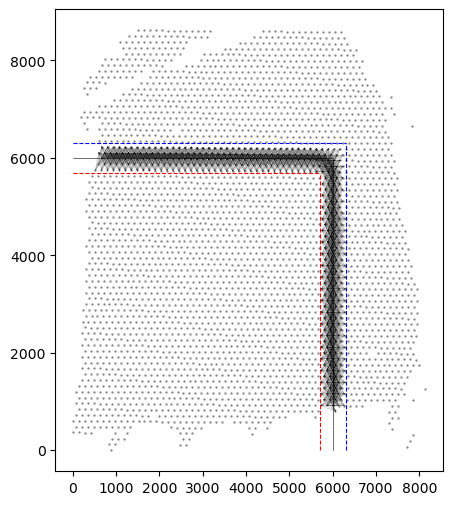

In [323]:
fig, ax = plt.subplots(figsize=(5,6))
diag_point = np.array([6000, 6000])
diag_point_pos = diag_point + 300
diag_point_neg = diag_point - 300
ax.scatter(loc_df['x'], loc_df['y'], c= "grey", s=0.4)
#sns.scatterplot(data = int_loc_df, x = "x", y = "y", s = 8, hue='dist_from_z', ax=ax, alpha=0.8,label='start')
ax.plot([0, diag_point[0]], diag_point, color = 'black', linewidth=0.4)
ax.plot(diag_point, [0, diag_point[1]], color = 'black', linewidth=0.4)

ax.plot([0, diag_point_pos[0]], diag_point_pos, color = 'blue', linewidth=0.8, linestyle='dashed')
ax.plot(diag_point_pos, [0, diag_point_pos[1]], color = 'blue', linewidth=0.8, linestyle='dashed')

ax.plot([0, diag_point_neg[0]], diag_point_neg, color = 'red', linewidth=0.8, linestyle='dashed')
ax.plot(diag_point_neg, [0, diag_point_neg[1]], color = 'red', linewidth=0.8, linestyle='dashed')

for edge in G_tmp_both.edges():
    x1, y1 = loc_df.loc[ G_tmp_both.nodes[edge[0]]['cell'], 'x' ], loc_df.loc[ G_tmp_both.nodes[edge[0]]['cell'], 'y' ]
    x2, y2 = loc_df.loc[ G_tmp_both.nodes[edge[1]]['cell'], 'x' ], loc_df.loc[ G_tmp_both.nodes[edge[1]]['cell'], 'y' ]
    ax.plot([x1, x2], [y1, y2], color='black',linewidth = 0.1)

In [324]:
max_matches = nx.maximal_matching(G_tmp_both)

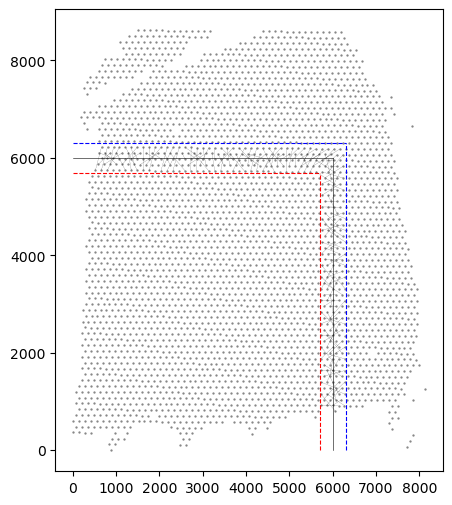

In [327]:
fig, ax = plt.subplots(figsize=(5,6))
diag_point = np.array([6000, 6000])
diag_point_pos = diag_point + 300
diag_point_neg = diag_point - 300
ax.scatter(loc_df['x'], loc_df['y'], c= "grey", s=0.4)
#sns.scatterplot(data = int_loc_df, x = "x", y = "y", s = 8, hue='dist_from_z', ax=ax, alpha=0.8,label='start')
ax.plot([0, diag_point[0]], diag_point, color = 'black', linewidth=0.4)
ax.plot(diag_point, [0, diag_point[1]], color = 'black', linewidth=0.4)

ax.plot([0, diag_point_pos[0]], diag_point_pos, color = 'blue', linewidth=0.8, linestyle='dashed')
ax.plot(diag_point_pos, [0, diag_point_pos[1]], color = 'blue', linewidth=0.8, linestyle='dashed')

ax.plot([0, diag_point_neg[0]], diag_point_neg, color = 'red', linewidth=0.8, linestyle='dashed')
ax.plot(diag_point_neg, [0, diag_point_neg[1]], color = 'red', linewidth=0.8, linestyle='dashed')

for edge in max_matches:
    x1, y1 = loc_df.loc[ G_tmp_both.nodes[edge[0]]['cell'], 'x' ], loc_df.loc[ G_tmp_both.nodes[edge[0]]['cell'], 'y' ]
    x2, y2 = loc_df.loc[ G_tmp_both.nodes[edge[1]]['cell'], 'x' ], loc_df.loc[ G_tmp_both.nodes[edge[1]]['cell'], 'y' ]
    ax.plot([x1, x2], [y1, y2], color='black',linewidth = 0.1)

In [390]:
loc_df.sort_values(['x', 'y'])

,x,y
cell,,
AGTAATTTGCAAGCGT-1,0,366
AATTGCGTGGATTACA-1,2,605
GTGGCCGGTTTCTCGG-1,70,485
CGATAGCGATACAGTG-1,72,724
GCCTTTGTCAGTGGAC-1,73,964
...,...,...
TACCATGTATTGATTT-1,7936,2822
CAAAGGTCATCTGAAA-1,7938,3061
AGAACCCAGCGTGACA-1,7940,3301


In [567]:
nop = 100
N = nop ** 2

# Generate positions
pos = np.array(np.meshgrid(np.arange(1, int(np.sqrt(N)) + 1), 
                           np.arange(1, int(np.sqrt(N)) + 1))).T.reshape(-1, 2)
pos = np.concatenate((pos, pos[::-1]), axis=0)
pos = np.unique(pos, axis=0)

# Assign row and column names
pos_names = [f'cell{i+1}' for i in range(N)]
df_pos = pd.DataFrame(pos, columns=['x', 'y'])
df_pos.index = pos_names
#pos = np.column_stack((pos, pos_names))

# Jitter
pos_j = df_pos + np.random.uniform(-0.2, 0.2, size = (N,2))

# Induce warping
#pos_w = 1.01 ** pos_j
pos_w = pos_j
#pos_w = 100 * pos_w

In [639]:
len(list(range(2500,4500,100)))

20

In [638]:
len(list(range(40,0,-2)))

20

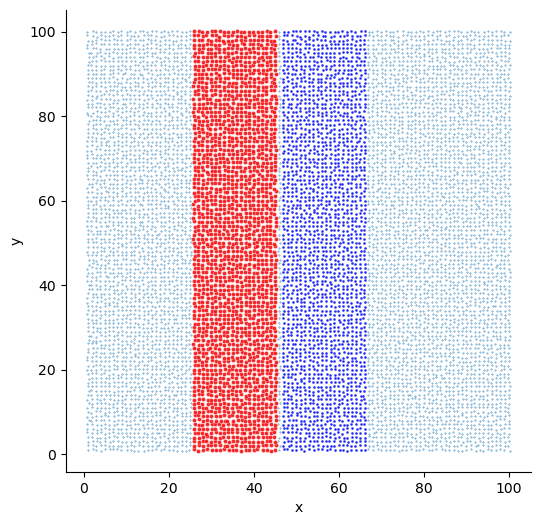

In [643]:
# Plotting
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(pos_w.x, pos_w.y,s=0.1);

start_x_vec = list(range(2500,4500,100))
gaps = list(range(40,0,-2))
for i in range(len(gaps)):
    start_x = start_x_vec[i]
    gap = gaps[i]
    sns.scatterplot(data = pos_w.iloc[ start_x: start_x + nop, ], x = "x", y = "y", s = 9, ax=ax, alpha=0.8, color='r');    
    sns.scatterplot(data = pos_w.iloc[ start_x + gap * nop: start_x + (gap+1) * nop, ], x = "x", y = "y", s = 4, ax=ax, alpha=0.8, color='blue');
sns.despine()

In [644]:
sim_coords = pos_w[[ 'x', 'y']].values

In [645]:
sim_edge_list = []
for i in range(len(gaps)):
    start_x = start_x_vec[i]
    gap = gaps[i]
    sim_edge_list += [(i,j,euclidean_distances(
        sim_coords[np.newaxis, i, :], 
        sim_coords[np.newaxis, j, :]
    )[0][0]) for (i,j) in zip(list(range(start_x , start_x + nop)), list(range(start_x + gap * nop, start_x + (gap+1) * nop)) ) ]

In [646]:
sim_edge_list_df = pd.DataFrame(sim_edge_list, columns = ['source', 'target', 'distance'])

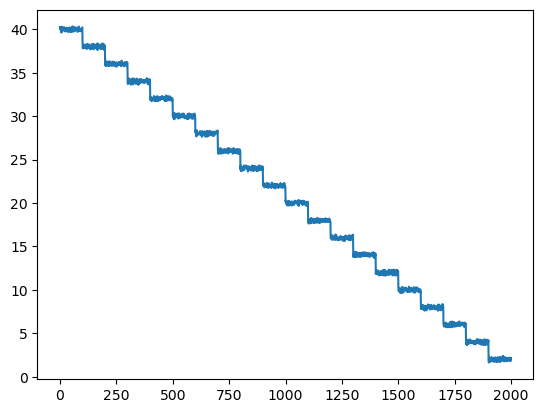

In [647]:
plt.plot(sim_edge_list_df.distance)

We will follow the correlation metrix

$\rho(h_{ij}) = \rho_0 \exp{(-d_{ij}\rho_1)},~ -1 \leq \rho_0 \leq 1,~ \rho_1 \ge 0 $

\begin{equation}
\mathbf{\Sigma} = \begin{bmatrix}
  1 & \rho_0 \exp{(-d_{ij}\rho_1)} \\
  \rho_0 \exp{(-d_{ij}\rho_1)} & 1 \\
\end{bmatrix}
\end{equation} 



In [817]:
sim_edge_list_df

,source,target,distance
0,2500,6500,40.248770
1,2501,6501,40.021005
2,2502,6502,40.257044
3,2503,6503,39.999618
4,2504,6504,39.916902
...,...,...,...
1995,4495,4695,2.062585
1996,4496,4696,1.830461
1997,4497,4697,2.061973
1998,4498,4698,1.885466


In [653]:
sim_edge_list_df.shape

(2000, 3)

In [787]:
rho_zero_vec = np.linspace(-0.9, 0.9, 19)
rho_one_vec = np.array([0.01,0.05]) # make it variable later
sparse_fraction = np.array([0.1, 0.3 , 0.5, 1.0])
mu_x_vec = np.array([-8, -5, -3])
mu_y_vec = np.array([-8, -5, -3])

param_values = [
    sparse_fraction,
    mu_x_vec,
    mu_y_vec,
    rho_zero_vec,
    rho_one_vec
]

param_grids = np.meshgrid(*param_values, indexing='ij')
grid_points = np.column_stack([grid.ravel() for grid in param_grids])
grid_points_df = pd.DataFrame(
    grid_points, 
    columns=['sparse_frac', 'mu_x', 'mu_y' ,'rho_zero', 'rho_one']
)

In [788]:
importlib.reload(model)

<module 'model' from '/n/fs/ragr-research/users/hirak/Projects/copulacci/src/copulacci/model.py'>

In [789]:
def sample_from_copula_dist(
    n_array,
    mu_x, 
    mu_y, 
    coeff_list,
    n_jobs = 20
):    
    lam_x = n_array * np.exp(mu_x)
    lam_y = n_array * np.exp(mu_y)

    # samples = Parallel(n_jobs=n_jobs, verbose=0)(
    #                 delayed(np.random.multivariate_normal)(
    #                     [0,0],
    #                     [[1, coeff], [coeff, 1]],
    #                     size = 1) for coeff in coeff_list)
    # samples = np.array(list(chain(*(samples))))
    
    samples = np.array([np.random.multivariate_normal(
            [0,0], 
            [[1,coeff],[coeff,1]], 
            size = 1
        ).squeeze() for coeff in coeff_list])
        
    samples = pd.DataFrame(samples, columns=['x', 'y'])
    cdf_x = stats.norm.cdf(samples.x)
    cdf_y = stats.norm.cdf(samples.y)
    samples.loc[:, 'x'] = stats.poisson.ppf(cdf_x, lam_x)
    samples.loc[:, 'y'] = stats.poisson.ppf(cdf_y, lam_y)
    
    return samples

In [790]:
import random
n_array_sum = np.array(random.sample(list(adata.to_df().sum(1)),sim_edge_list_df.shape[0]))

In [791]:
def copula_dist_caller(args):
    sparse_frac, mu_x, mu_y, rho_zero, rho_one, global_idx = args
    _n_array = (n_array_sum * sparse_frac).astype('int')
    coeff_list = rho_zero * np.exp(-1 * sim_edge_list_df.distance * rho_one)
    
    sample = sample_from_copula_dist(
        _n_array,
        mu_x, 
        mu_y, 
        coeff_list
    )
    sample.columns = ['L'+str(int(global_idx)), 'R'+str(int(global_idx))]
    return sample

In [792]:
grid_points_df.loc[:, 'ind'] = np.array(range(grid_points_df.shape[0])).astype('int')

In [793]:
arg_list = grid_points_df.values.tolist()

In [794]:
samples = Parallel(n_jobs=20, verbose=1)(
                delayed(copula_dist_caller)(
                    args) for args in arg_list)

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    2.5s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    4.8s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:    8.2s
[Parallel(n_jobs=20)]: Done 760 tasks      | elapsed:   12.9s
[Parallel(n_jobs=20)]: Done 1210 tasks      | elapsed:   18.8s
[Parallel(n_jobs=20)]: Done 1368 out of 1368 | elapsed:   21.1s finished


In [795]:
pseudo_count = pd.concat(samples, axis = 1)

In [796]:
def show_pattern(pos_w, sim_edge_list_df, pseudo_count, i):
    tmp_source = pos_w.iloc[sim_edge_list_df.source,:].copy()
    tmp_source.loc[:,'gene'] = pseudo_count.loc[:, 'L' + str(i)].values
    tmp_end = pos_w.iloc[sim_edge_list_df.target,:].copy()
    tmp_end.loc[:,'gene'] = pseudo_count.loc[:, 'R' + str(i)].values
    tmp_dist = pd.concat([tmp_source, tmp_end])
    
    fig, ax = plt.subplots(figsize=(7, 6))
    ax.scatter(pos_w.x, pos_w.y,s=0.01,alpha=1,color='grey');
    tmp_dist.loc[:, 'gene_log'] = np.log( tmp_dist.gene + 1 )
    sns.scatterplot(data= tmp_dist, x="x", y="y", hue="gene_log", palette="Reds",  s=2, linewidth=0, alpha=1, ax=ax)
    
    norm = plt.Normalize(tmp_dist['gene_log'].min(), tmp_dist['gene_log'].max())
    sm = plt.cm.ScalarMappable(cmap="Reds", norm=norm)
    sm.set_array([])
    
    # Remove the legend and add a colorbar
    ax.get_legend().remove()
    ax.figure.colorbar(sm)
    plt.show()

<Axes: xlabel='x', ylabel='y'>

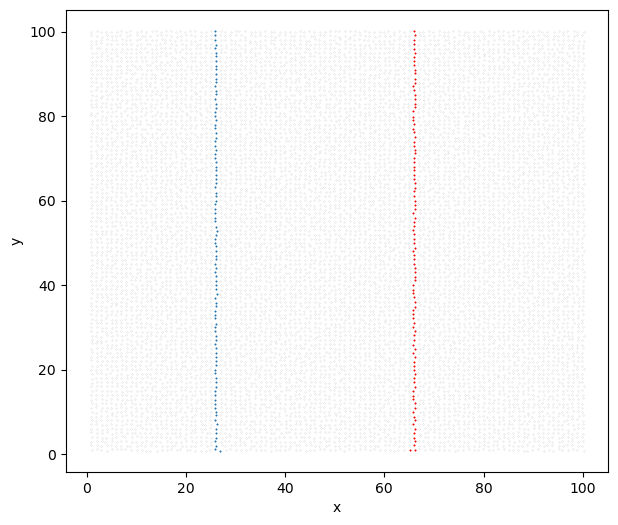

In [797]:
fig, ax = plt.subplots(figsize=(7, 6))
ax.scatter(pos_w.x, pos_w.y,s=0.01,alpha=1,color='grey');
sns.scatterplot(data= pos_w.iloc[ sim_edge_list_df.loc[:100,'source'] ], x="x", y="y",  s=2, linewidth=0, alpha=1, ax=ax)
sns.scatterplot(data= pos_w.iloc[ sim_edge_list_df.loc[:100,'target'] ], x="x", y="y", c='r', s=2, linewidth=0, alpha=1, ax=ax)

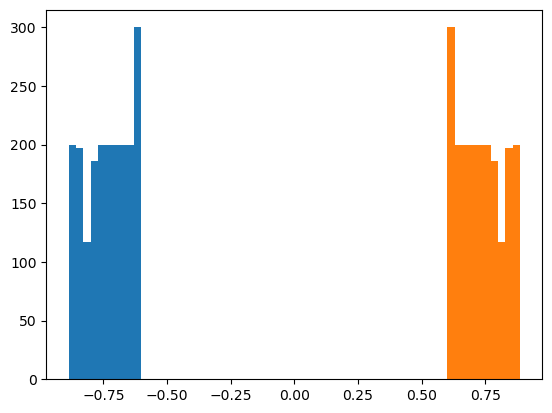

In [799]:
plt.hist(-0.9 * np.exp( - sim_edge_list_df.distance.values * 0.01 ));
plt.hist(0.9 * np.exp( - sim_edge_list_df.distance.values * 0.01 ));

In [800]:
grid_points_df.loc[
    ((grid_points_df.rho_zero == 0.9) | (grid_points_df.rho_zero == -0.9)) &
    (grid_points_df.mu_x == -5.0) &
    (grid_points_df.mu_y == -5.0) &
    (grid_points_df.sparse_frac == 0.3)
]

,sparse_frac,mu_x,mu_y,rho_zero,rho_one,ind
494,0.3,-5.0,-5.0,-0.9,0.01,494
495,0.3,-5.0,-5.0,-0.9,0.05,495
530,0.3,-5.0,-5.0,0.9,0.01,530
531,0.3,-5.0,-5.0,0.9,0.05,531


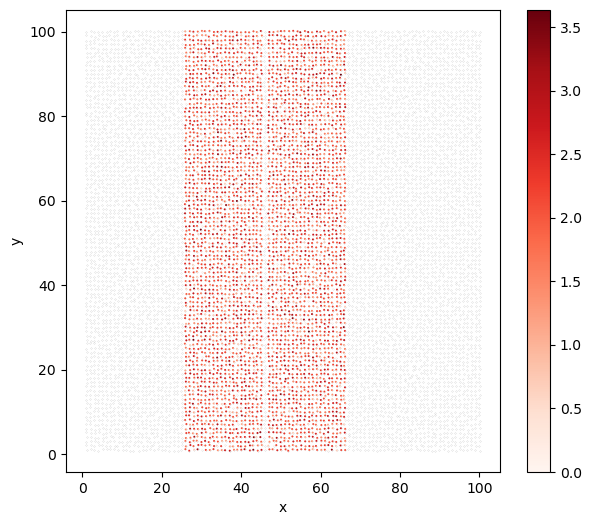

In [801]:
show_pattern(pos_w, sim_edge_list_df, pseudo_count, 494	)

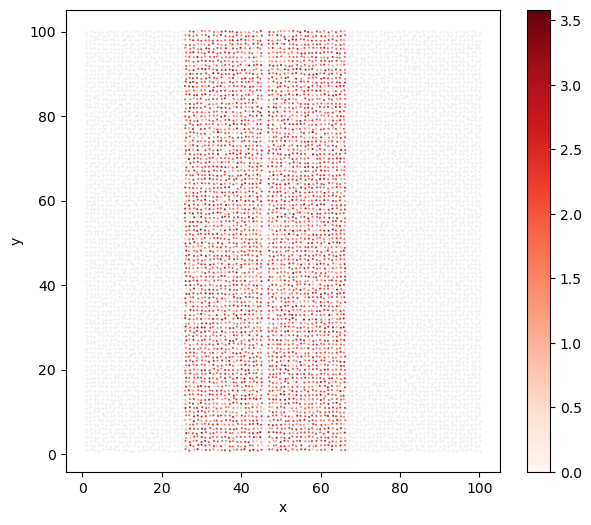

In [803]:
show_pattern(pos_w, sim_edge_list_df, pseudo_count, 530)

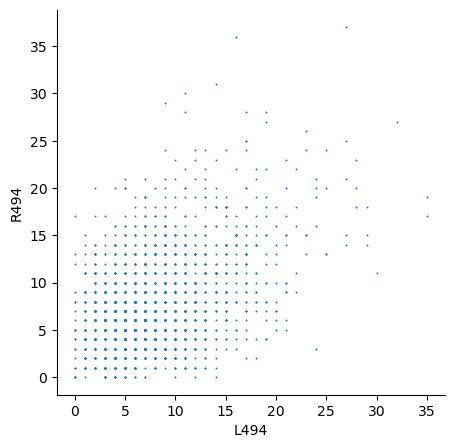

In [1108]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(data = pseudo_count, x = 'L494', y = 'R494',s=2,
                linewidth=0, ax = ax)
sns.despine()

<Axes: xlabel='L530', ylabel='R530'>

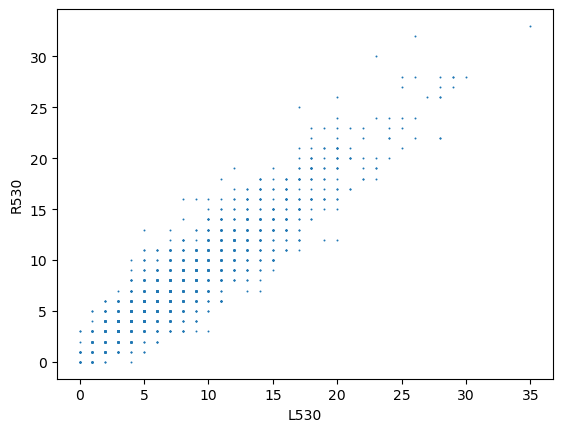

In [804]:
sns.scatterplot(data = pseudo_count, x = 'L530', y = 'R530',s=2,linewidth=0)

In [818]:
data_list = []
i = 0
for row in tqdm.tqdm(grid_points_df.iterrows()):
    sparse_frac, mu_x, mu_y, rho_zero, rho_one, _ = row[1]
    _n_array = (n_array_sum * sparse_frac).astype('int')
    data_list += [
        (
            pseudo_count.loc[:, 'L'+str(i)].values.astype('int'),
            pseudo_count.loc[:, 'R'+str(i)].values.astype('int'),
            mu_x, mu_y,
            _n_array.copy()
            
        )
    ]
    i += 1

1368it [00:00, 6105.13it/s]


In [1032]:
from scipy.optimize import minimize, minimize_scalar
EPSILON = 1.1920929e-07
def get_dt_cdf(x, lam, DT=True):
    u_x = stats.poisson.cdf(x, lam).clip(EPSILON, 1 - EPSILON)
    u_x2 = stats.poisson.cdf(x-1, lam).clip(EPSILON, 1 - EPSILON)
    if DT:
        v = stats.uniform.rvs(size=len(x))
        r = u_x * v + u_x2 * (1 - v)
    else:
        r = (u_x + u_x2) / 2.0
    #r = (u_x + u_x2) / 2.0
    #r = u_x2
    # remove too low / too big
    idx_adjust = np.where(1 - r < EPSILON)[0]
    r[ idx_adjust ] = r[ idx_adjust ] - EPSILON
    idx_adjust = np.where(r < EPSILON)[0]
    r[ idx_adjust ] = r[ idx_adjust ] + EPSILON

    return stats.norm.ppf(r)

    

def log_joint_lik_perm_dist(params, umi_sum_1, umi_sum_2, x, y, dist_list, perm=100, DT=True, model = 'copula'):
    # get lam parameters for mu_1
    rho_zero = params[0]
    rho_one = params[1]
    coeff_list = rho_zero * np.exp(-1 * sim_edge_list_df.distance * rho_one)
    mu_1 = params[2]
    mu_2 = params[3]
    
    lam1 = umi_sum_1 * np.exp(mu_1)
    lam2 = umi_sum_2 * np.exp(mu_2)
    
    # get z
    r_x = get_dt_cdf(x, lam1, DT=DT)
    r_y = get_dt_cdf(y, lam2, DT=DT)
    if DT:
        for _ in range(perm-1):    
            r_x += get_dt_cdf(x, lam1)
            r_y += get_dt_cdf(y, lam2)
        z = np.column_stack([r_x/perm, r_y/perm])
    else:
        z = np.column_stack([r_x, r_y])
    
    # term1
    det = 1 - coeff_list**2
    term1 = np.sum(-0.5 * (((coeff_list**2)/det) * ((z[:,0]**2) + (z[:,1] ** 2)) - 2 * (coeff_list/det) * z[:,0] * z[:,1]) )
    
    term2 = (
        np.sum(np.log( stats.poisson.pmf(x, lam1).clip(EPSILON, 1 - EPSILON) )) +
        np.sum(np.log(stats.poisson.pmf(y, lam2).clip(EPSILON, 1 - EPSILON) ))
    )
    
    term3 = np.sum(-0.5 * np.log(det+EPSILON))
    logsum = term1 + term2 + term3
   
    return -logsum

def call_optimizer_dense(
    _x, 
    _y, 
    _umi_sum_1, 
    _umi_sum_2,
    dist_list,
    rho_one_start = 0.01,
    method = 'Nelder-Mead',
    perm=10,
    DT = True,
    cutoff=0.6,
    length_cutoff=20,
    model='copula',
    num_restarts = 50,
    force = False
):
    x = _x.copy()
    y = _y.copy()
    if (np.isnan( stats.spearmanr(x / _umi_sum_1, y / _umi_sum_2).correlation )):
        
        return ([ 0, 0, 0, 0 , 'skip' ])
    if ( (x.sum() == 0) or (y.sum() == 0) ):
        
        return ([ 0, 0, 0, 0 , 'skip' ])
    if len(x) < length_cutoff:
        
        return ([ 0, 0, 0, 0 , 'skip' ])
    umi_sum_1 = _umi_sum_1.copy()
    umi_sum_2 = _umi_sum_2.copy()
    method_type = model

    if not force:
        # If either of the arrays are too sparse we would run  
        # gaussian extimate rather than anything else
        
        if ( ((x==0).sum() / len(x) > cutoff) | ((y==0).sum() / len(y) > cutoff) ):
            
            method_type = 'skip'
        
    
    results = []
    mu_x_start = np.log(x.sum() / umi_sum_1.sum())
    mu_y_start = np.log(y.sum() / umi_sum_2.sum())
    if method_type == 'skip':
        return ([ 0, 0, 0, 0 , 'skip' ])
    else:
        for _ in range(num_restarts):
            res = minimize(
                log_joint_lik_perm_dist, 
                x0=[0.0,rho_one_start,mu_x_start,mu_y_start], 
                method = method, 
                bounds = [(-0.99, 0.99),
                          (0.0, 0.1),
                          (mu_x_start-5, 0),
                          (mu_y_start-5, 0)], 
                args=(umi_sum_1,umi_sum_2,x,y, dist_list,perm,DT,"copula"), 
                tol=1e-6
            )
            results += [res.copy()]
        best_result = min(results, key=lambda x: x['fun'])
        return list(best_result['x']) + ['copula']

In [1033]:
(x,y,_,_,_n_array) = data_list[173]

In [1034]:
umi_sums = _n_array
lik0 = []
lik1 = []
for i in np.linspace(-0.99, 0.99, 100):
    lik0 += [ log_joint_lik_perm_dist(
        [ i, 0.1, np.log(x.sum() / umi_sums.sum()), np.log(y.sum() / umi_sums.sum()) ], 
        umi_sums, 
        umi_sums, 
        x, 
        y, 
        sim_edge_list_df.distance.values,
        perm=1, 
        DT=False) 
    ]   
    lik1 += [ log_joint_lik_perm_dist(
        [ i, 0.01, np.log(x.sum() / umi_sums.sum()), np.log(y.sum() / umi_sums.sum()) ], 
        umi_sums, 
        umi_sums, 
        x, 
        y, 
        sim_edge_list_df.distance.values,
        perm=1, 
        DT=False) 
    ]   

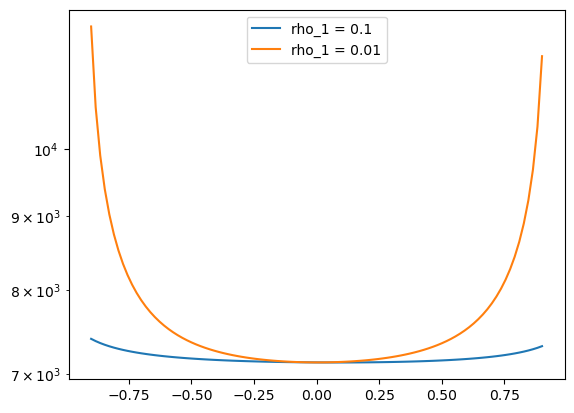

In [1035]:
plt.plot(np.linspace(-0.9, 0.9, 100), lik0, label='rho_1 = 0.1')
plt.plot(np.linspace(-0.9, 0.9, 100), lik1, label='rho_1 = 0.01')
plt.legend();
plt.yscale('log')

In [1037]:
call_optimizer_dense(
    x,
    y,
    _n_array,
    _n_array,
    sim_edge_list_df.distance.values,
    method='Powell',
    perm=20,
    DT=False,
    cutoff=0.9,
    num_restarts = 1
)

[0.09070429458159271,
 0.09999999999986221,
 -4.992033903048894,
 -4.995751697777424,
 'copula']

In [1038]:
opt_res = Parallel(n_jobs=20, verbose=1)(
        delayed(call_optimizer_dense)(
        x,
        y,
        _n_array,
        _n_array,
        sim_edge_list_df.distance.values,
        method='Powell',
        perm=20,
        DT=False,
        cutoff=0.9,
        num_restarts = 1
        ) for (x,y,_,_,_n_array) in data_list)

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    4.1s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:   13.6s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:   28.3s
[Parallel(n_jobs=20)]: Done 760 tasks      | elapsed:   48.7s
[Parallel(n_jobs=20)]: Done 1210 tasks      | elapsed:  1.2min
[Parallel(n_jobs=20)]: Done 1368 out of 1368 | elapsed:  1.4min finished


In [1039]:
opt_res_df = pd.DataFrame(opt_res, columns=['pred_corr_zero', 'pred_corr_one' ,'pred_mu_x','pred_mu_y','method'])

In [1040]:
opt_res_df.loc[opt_res_df.method == 'copula']

,pred_corr_zero,pred_corr_one,pred_mu_x,pred_mu_y,method
0,-0.730123,7.164279e-04,-7.750778,-7.676063,copula
1,-0.698471,2.079229e-04,-7.732380,-7.683344,copula
2,-0.748426,1.629286e-03,-7.711121,-7.665903,copula
3,-0.724972,2.052629e-03,-7.651377,-7.716132,copula
4,-0.709059,5.960857e-07,-7.677368,-7.721810,copula
...,...,...,...,...,...
1363,0.667973,4.692502e-02,-3.000040,-3.001694,copula
1364,0.806191,1.161911e-02,-3.000437,-3.000869,copula
1365,0.751943,4.391814e-02,-2.999243,-3.000118,copula
1366,0.900405,9.588340e-03,-2.998554,-2.999727,copula


In [1041]:
count_df_norm = pseudo_count.div(pseudo_count.sum(1), axis = 0) 
count_df_norm_log = np.log( count_df_norm + 1 )

In [1042]:
data_list_norm = []

for row in tqdm.tqdm(grid_points_df.iterrows()):
    sparse_frac, mu_x, mu_y, rho_zero, rho_one, i = row[1]
    _n_array = (n_array * sparse_frac).astype('int')
    data_list_norm += [
        (
            count_df_norm.loc[:, 'L'+str(int(i))],
            count_df_norm.loc[:, 'R'+str(int(i))]
        )
    ]
    i += 1

data_list_log = []

for row in tqdm.tqdm(grid_points_df.iterrows()):
    sparse_frac, mu_x, mu_y, rho_zero, rho_one, i = row[1]
    _n_array = (n_array * sparse_frac).astype('int')
    data_list_log += [
        (
            count_df_norm_log.loc[:, 'L'+str(int(i))],
            count_df_norm_log.loc[:, 'R'+str(int(i))]
        )
    ]
    

1368it [00:00, 4924.36it/s]
1368it [00:00, 4908.94it/s]


In [1043]:
grid_points_df

,sparse_frac,mu_x,mu_y,rho_zero,rho_one,ind
0,0.1,-8.0,-8.0,-0.9,0.01,0
1,0.1,-8.0,-8.0,-0.9,0.05,1
2,0.1,-8.0,-8.0,-0.8,0.01,2
3,0.1,-8.0,-8.0,-0.8,0.05,3
4,0.1,-8.0,-8.0,-0.7,0.01,4
...,...,...,...,...,...,...
1363,1.0,-3.0,-3.0,0.7,0.05,1363
1364,1.0,-3.0,-3.0,0.8,0.01,1364
1365,1.0,-3.0,-3.0,0.8,0.05,1365
1366,1.0,-3.0,-3.0,0.9,0.01,1366


In [1094]:
def prepare_df(opt_res):
    spr = []
    spr2 = []
    spr3 = []
    spr4 = []
    for (x,y,_,_,_n_array) in data_list:
        #inds = np.where((x > 0) | (y > 0))[0]
        spr += [stats.spearmanr(x, y).correlation]

    for (x,y,_,_,_n_array) in data_list:
        #inds = np.where((x > 0) | (y > 0))[0]
        #spr2 += [stats.spearmanr(( x[inds] / _n_array[inds] ), ( y[inds] / _n_array[inds] )).correlation]
        spr2 += [stats.pearsonr(x, y).correlation]

    for (x,y) in data_list_norm:
        #inds = np.where((x > 0) | (y > 0))[0]
        #spr2 += [stats.spearmanr(( x[inds] / _n_array[inds] ), ( y[inds] / _n_array[inds] )).correlation]
        spr3 += [stats.pearsonr(x, y).correlation]

    for (x,y) in data_list_log:
        #inds = np.where((x > 0) | (y > 0))[0]
        #spr2 += [stats.spearmanr(( x[inds] / _n_array[inds] ), ( y[inds] / _n_array[inds] )).correlation]
        spr4 += [stats.spearmanr(x, y).correlation]

    
    opt_res_df = pd.DataFrame(opt_res, columns=['pred_corr_zero', 'pred_corr_one' ,'pred_mu_x','pred_mu_y','method'])
    opt_res_df = opt_res_df.loc[opt_res_df.method == 'copula']
    opt_res_df = opt_res_df[['pred_corr_zero', 'pred_corr_one', 'pred_mu_x','pred_mu_y']].copy()
    opt_res_df = pd.concat([grid_points_df, opt_res_df], axis = 1)
    opt_res_df['spearman'] = spr
    opt_res_df['pearson'] = spr2
    opt_res_df['spearman_log_norm'] = spr4
    opt_res_df['pearson_norm'] = spr3

    
    
    
    opt_res_df['copula_diff'] = opt_res_df.rho_zero - opt_res_df.pred_corr_zero
    opt_res_df['copula_one_diff'] = opt_res_df.rho_zero - opt_res_df.pred_corr_one
    opt_res_df['spearman_diff'] = opt_res_df.rho_zero - opt_res_df.spearman
    opt_res_df['pearson_diff'] = opt_res_df.rho_zero - opt_res_df.pearson
    opt_res_df['spearman_log_norm_diff'] = opt_res_df.rho_zero - opt_res_df.spearman_log_norm
    opt_res_df['pearson_norm_diff'] = opt_res_df.rho_zero - opt_res_df.pearson_norm
    #opt_res_df= opt_res_df.fillna(0)
    
    
    zero_ratio = (pseudo_count == 0).mean()
    opt_res_df.loc[:,'zero_ratio'] = [(zero_ratio.iloc[i] + zero_ratio.iloc[i + 1]) / 2 for i in range(0, len(zero_ratio) - 1, 2)]
    
    opt_res_df.loc[:,'zr_cat'] = pd.cut(opt_res_df.zero_ratio, bins=[-1.0,0.25,0.5,0.75,1.0], labels = ['below_25', 
                                                                            '25_50',
                                                                            '50_75',
                                                                             '75_100'
                                                                            ])
    
    
    
    opt_res_df.loc[:,'orig_index'] = opt_res_df.index
    
    res_df_melted = pd.melt(opt_res_df, 
            id_vars = ['mu_x','mu_y', 'zr_cat', 'sparse_frac','rho_zero', 'rho_one','orig_index'], 
            value_vars=['copula_diff', 'spearman_diff','pearson_diff','spearman_log_norm_diff','pearson_norm_diff'],
            var_name = 'method', value_name = 'difference')

    
    
    opt_res_df['method_diff'] = abs(opt_res_df.copula_diff) - abs(opt_res_df.spearman_diff)

    return (res_df_melted, opt_res_df)

In [1095]:
res_df_melted, opt_res_df = prepare_df(opt_res)

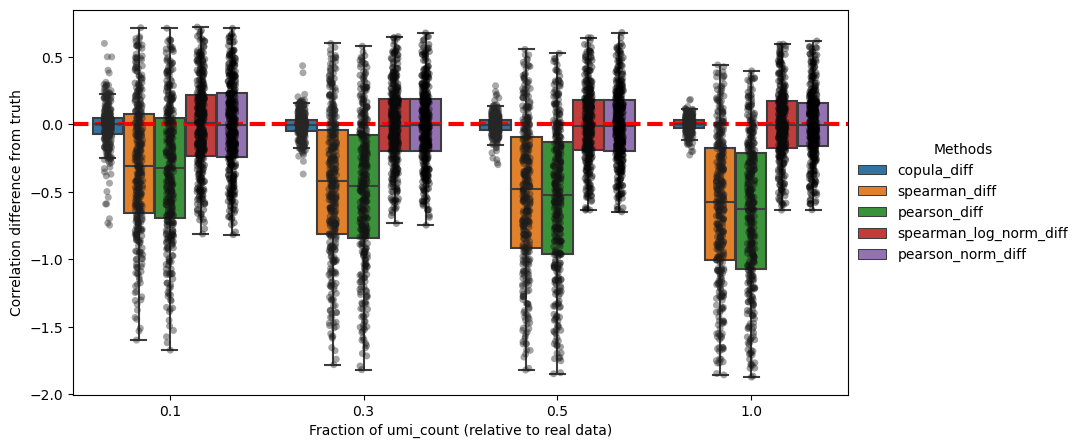

In [1047]:
plt.figure(figsize=(10, 5))
sns.stripplot(x="sparse_frac", y="difference", hue="method",
              data=res_df_melted ,
              jitter=True,
              palette='dark:black',
              legend = None,
              #palette="Set5", 
              alpha = 0.4,
              dodge=True,linewidth=0,edgecolor='gray')

sns.boxplot(x="sparse_frac", y="difference", hue="method",
            data=res_df_melted,
            #palette="Set5",
            fliersize=0)

plt.xlabel('Fraction of umi_count (relative to real data)', fontsize = 10)
plt.ylabel('Correlation difference from truth', fontsize = 10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.axhline(y=0, c = 'r', linewidth = 3, linestyle='--')
#plt.legend(title="Legend", bbox_to_anchor=(1, 1), loc='upper left');
leg = plt.legend(title="Methods", loc='right', bbox_to_anchor=(1.3,0.5),
          frameon=False);
plt.setp(leg.texts, fontsize='10')

plt.show()

<Axes: >

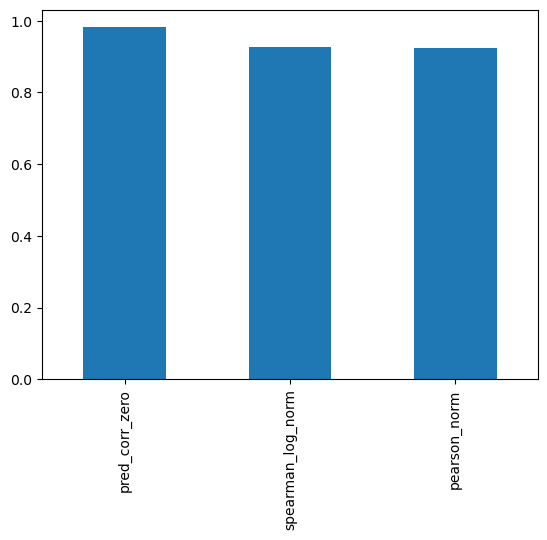

In [1092]:
opt_res_df[[
    'rho_zero',
    'pred_corr_zero',
    # 'spearman',
    # 'pearson',
    'spearman_log_norm',
    'pearson_norm'
]].corr().iloc[0,1:].plot(kind='bar')

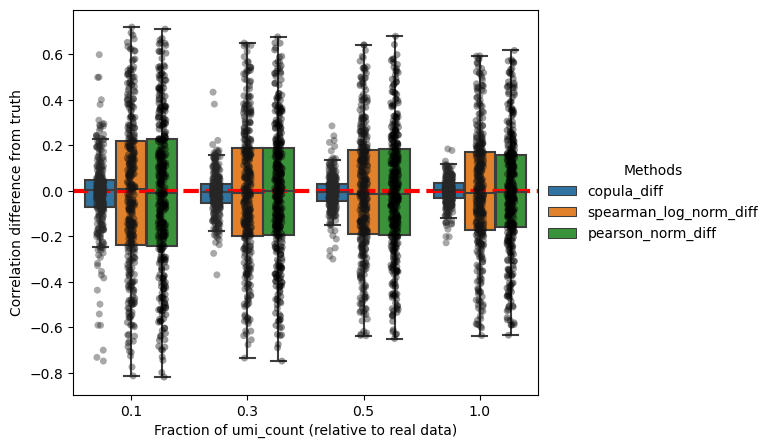

In [1049]:
plt.figure(figsize=(6, 5))
tmp = res_df_melted.loc[res_df_melted.method.isin(['copula_diff', 'spearman_log_norm_diff', 'pearson_norm_diff'])]
sns.stripplot(x="sparse_frac", y="difference", hue="method",
              data=tmp ,
              jitter=True,
              palette='dark:black',
              legend = None,
              #palette="Set5", 
              alpha = 0.4,
              dodge=True,linewidth=0,edgecolor='gray')

sns.boxplot(x="sparse_frac", y="difference", hue="method",
            data=tmp,
            #palette="Set5",
            fliersize=0)

plt.xlabel('Fraction of umi_count (relative to real data)', fontsize = 10)
plt.ylabel('Correlation difference from truth', fontsize = 10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.axhline(y=0, c = 'r', linewidth = 3, linestyle='--')
#plt.legend(title="Legend", bbox_to_anchor=(1, 1), loc='upper left');
leg = plt.legend(title="Methods", loc='right', bbox_to_anchor=(1.5,0.5),
          frameon=False);
plt.setp(leg.texts, fontsize='10')

plt.show()

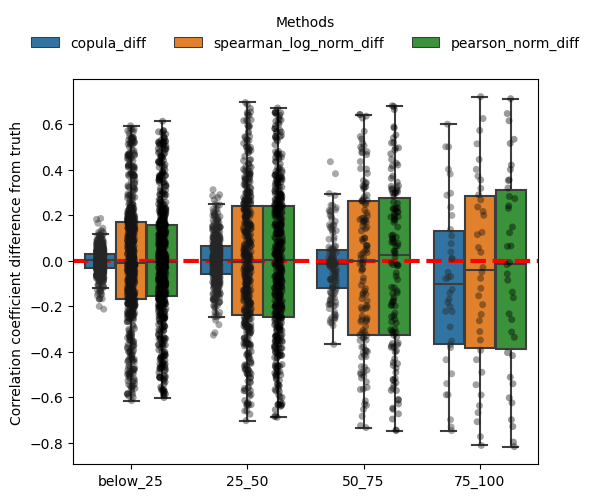

In [1050]:
plt.figure(figsize=(6, 5))
tmp = res_df_melted.loc[res_df_melted.method.isin(['copula_diff', 'spearman_log_norm_diff', 'pearson_norm_diff'])]

sns.stripplot(x="zr_cat", y="difference", hue="method",
              data=tmp ,
              jitter=True,
              palette='dark:black',
              legend = None,
              #palette="Set5", 
              alpha = 0.4,
              dodge=True,linewidth=0,edgecolor='gray')

sns.boxplot(x="zr_cat", y="difference", hue="method",
            data=tmp,
            #palette="Set5",
            fliersize=0)

plt.xlabel('', fontsize = 10)
plt.ylabel('Correlation coefficient difference from truth', fontsize = 10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.axhline(y=0, c = 'r', linewidth = 3, linestyle='--')
#plt.legend(title="Legend", bbox_to_anchor=(1, 1), loc='upper left');
leg = plt.legend(title="Methods", loc='upper center', bbox_to_anchor=(0.5, 1.2),
          ncol=5,frameon=False);
plt.setp(leg.texts, fontsize='10')
plt.show()

In [1055]:
opt_res_df[['rho_zero', 'rho_one', 'ind',
       'pred_corr_zero', 'pred_corr_one','spearman',
       'pearson']]

,rho_zero,rho_one,ind,pred_corr_zero,pred_corr_one,spearman,pearson
0,-0.9,0.01,0,-0.730123,7.164279e-04,-0.124732,-0.113973
1,-0.9,0.05,1,-0.698471,2.079229e-04,-0.082321,-0.076878
2,-0.8,0.01,2,-0.748426,1.629286e-03,-0.130964,-0.120278
3,-0.8,0.05,3,-0.724972,2.052629e-03,-0.091422,-0.084325
4,-0.7,0.01,4,-0.709059,5.960857e-07,-0.105687,-0.101114
...,...,...,...,...,...,...,...
1363,0.7,0.05,1363,0.667973,4.692502e-02,0.978069,0.986317
1364,0.8,0.01,1364,0.806191,1.161911e-02,0.988882,0.993058
1365,0.8,0.05,1365,0.751943,4.391814e-02,0.979091,0.986781
1366,0.9,0.01,1366,0.900405,9.588340e-03,0.992460,0.994962


In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=3, sharey=True, sharex=True, figsize=(3, 9))
for i, sparse_frac in enumerate(sparse_fraction):
    

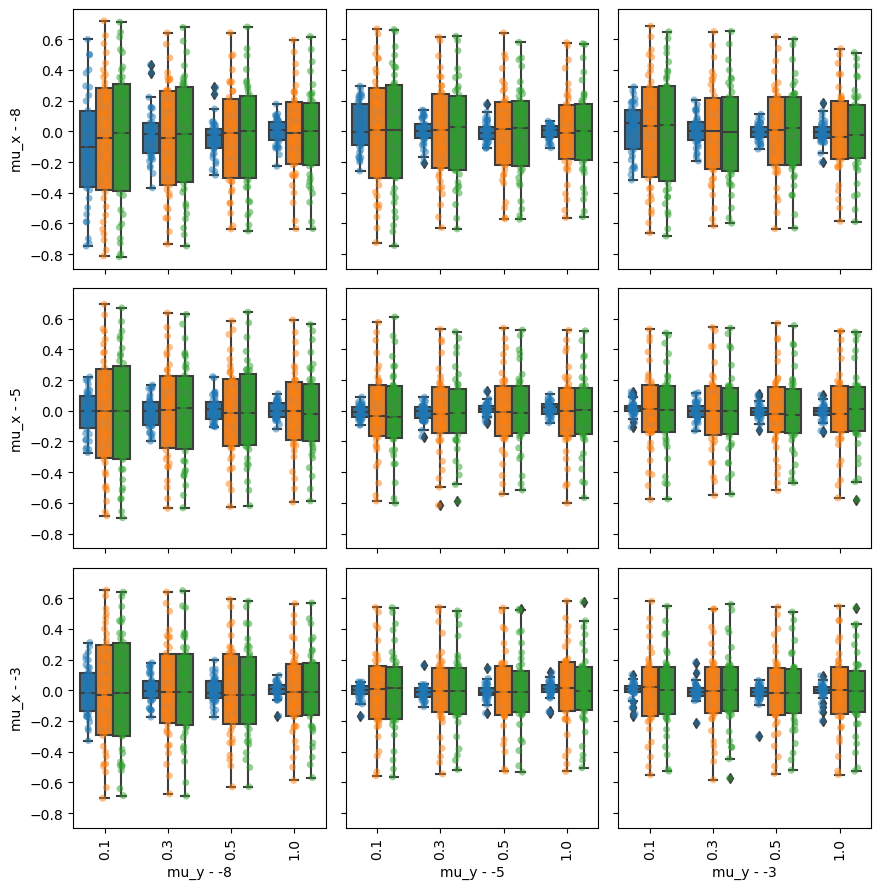

In [1051]:
fig, axes = plt.subplots(nrows=3, ncols=3, sharey=True, sharex=True, figsize=(9, 9))
for i, _mu_x in enumerate(mu_x_vec):
    for j, _mu_y in enumerate(mu_y_vec):
        df_tmp = tmp.loc[(res_df_melted.mu_x == _mu_x) & (res_df_melted.mu_y == _mu_y)]
        sns.stripplot(data = df_tmp,
                       x="sparse_frac", y="difference", hue="method",
                       jitter=True,
                       #palette='dark:black',
                       legend = None, 
                       dodge=True,linewidth=0,edgecolor='gray',
                       alpha = 0.5,
                       ax = axes[i,j]
                      )
        sns.boxplot(data = df_tmp, 
                       x="sparse_frac", y="difference", hue="method",
                       ax = axes[i,j]
                      )
        axes[i,j].get_legend().remove()
        axes[i, j].set_xlabel("")
        axes[i, j].set_ylabel("")
        if i != 2:
            axes[i, j].set_xticklabels([])
        else:
            axes[i, j].set_xticklabels(axes[i, j].get_xticklabels(), rotation=90)
            axes[i, j].set_xlabel('mu_y - '+str(_mu_y))
        if j == 0:
            axes[i, j].set_ylabel('mu_x - '+str(_mu_x))
plt.tight_layout()

In [466]:
0.1 * np.exp(- sim_edge_list_df.distance * 1.0)

0      0.014906
1      0.012933
2      0.010409
3      0.013748
4      0.011781
         ...   
795    0.000988
796    0.000642
797    0.000751
798    0.000579
799    0.000738
Name: distance, Length: 800, dtype: float64

In [451]:


param_values = [
    sparse_fraction,
    mu_x,
    mu_y,
    rho_vec
]

param_grids = np.meshgrid(*param_values, indexing='ij')
grid_points = np.column_stack([grid.ravel() for grid in param_grids])
grid_points_df = pd.DataFrame(
    grid_points, 
    columns=['sparse_frac', 'mu_x', 'mu_y' ,'rho']
)

global_idx = 0
pseudo_count = pd.DataFrame()

import tqdm

for row in tqdm.tqdm(grid_points_df.iterrows()):
    sparse_frac, mu_x, mu_y, rho = row[1]
    _n_array = (n_array * sparse_frac).astype('int')
    
    
    sample = model.sample_from_copula(
        _n_array,
        mu_x, 
        mu_y, 
        rho
    )
    sample.columns = ['L'+str(global_idx), 'R'+str(global_idx)]
    pseudo_count = pd.concat([pseudo_count, sample.copy()], axis = 1)
    global_idx += 1

[3721.0,
 2166.0,
 4282.0,
 4986.0,
 4981.0,
 4501.0,
 1465.0,
 3878.0,
 3929.0,
 2352.0,
 4291.0,
 4967.0,
 2630.0,
 3551.0,
 6474.0,
 2554.0,
 2926.0,
 3991.0,
 3749.0,
 2582.0,
 4766.0,
 1553.0,
 6990.0,
 3931.0,
 6713.0,
 3658.0,
 3471.0,
 3325.0,
 1768.0,
 3798.0,
 2418.0,
 3881.0,
 4008.0,
 2161.0,
 860.0,
 3726.0,
 4502.0,
 3658.0,
 4224.0,
 2579.0,
 5516.0,
 2035.0,
 2724.0,
 3483.0,
 919.0,
 5529.0,
 3625.0,
 4661.0,
 1222.0,
 4967.0,
 3641.0,
 2010.0,
 2761.0,
 4883.0,
 3849.0,
 3140.0,
 5557.0,
 3768.0,
 3332.0,
 7430.0,
 2307.0,
 4818.0,
 3020.0,
 1251.0,
 3569.0,
 12446.0,
 4507.0,
 1483.0,
 3740.0,
 3982.0,
 1396.0,
 2347.0,
 3916.0,
 5047.0,
 5194.0,
 6568.0,
 5403.0,
 4532.0,
 1644.0,
 3754.0,
 7630.0,
 706.0,
 4442.0,
 3502.0,
 4588.0,
 9232.0,
 6489.0,
 1057.0,
 2852.0,
 7945.0,
 2623.0,
 6470.0,
 3683.0,
 2153.0,
 4202.0,
 2271.0,
 1514.0,
 2896.0,
 2644.0,
 5343.0,
 3914.0,
 2769.0,
 6047.0,
 7074.0,
 4988.0,
 2270.0,
 2475.0,
 2541.0,
 2697.0,
 3962.0,
 2701.0,
 37

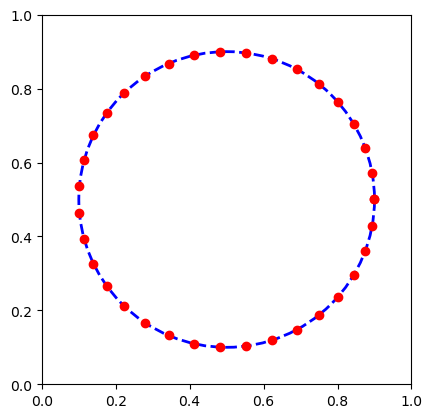

In [188]:
import matplotlib.pyplot as plt
import numpy as np

# Define the center of the circle
center = (0.5, 0.5)

# Define the radius of the circle
radius = 0.4

# Number of points on the circle
num_points = 36  # You can adjust this for more or fewer points

# Calculate the coordinates for points on the circle
theta = np.linspace(0, 2 * np.pi, num_points)
x = center[0] + radius * np.cos(theta)
y = center[1] + radius * np.sin(theta)

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the circle
circle = plt.Circle(center, radius, fill=False, linestyle='dashed', linewidth=2, edgecolor='b')
ax.add_patch(circle)

# Plot the points on the boundary
ax.plot(x, y, marker='o', color='r', linestyle='')

# Set the aspect ratio to be equal
ax.set_aspect('equal')

# Set axis limits to show the entire circle
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

# Display the plot
plt.show()


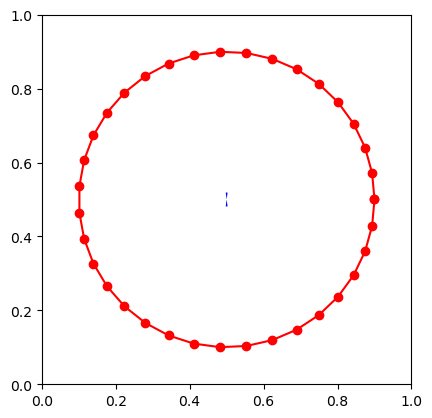

In [190]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

# Define the center of the circle
center = (0.5, 0.5)

# Define the radius of the circle
radius = 0.4

# Number of points on the circle
num_points = 36

# Generate points on the circle
theta = np.linspace(0, 2 * np.pi, num_points)
x = center[0] + radius * np.cos(theta)
y = center[1] + radius * np.sin(theta)

# Define the function to fit (equation of a circle)
def circle(x, a, b, r):
    return np.sqrt((x[0] - a) ** 2 + (x[1] - b) ** 2) - r

# Fit the curve (circle) to the points
params, covariance = curve_fit(circle, (x, y), radius, method='lm')

# Extract the parameters of the fitted circle
fitted_center = (params[0], params[1])
fitted_radius = params[2]

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the points on the boundary
ax.plot(x, y, marker='o', color='r', linestyle='-')

# Plot the fitted circle
fitted_circle = plt.Circle(fitted_center, fitted_radius, fill=False, linestyle='dashed', linewidth=10, edgecolor='b')
ax.add_patch(fitted_circle)

# Set the aspect ratio to be equal
ax.set_aspect('equal')

# Set axis limits to show the entire circle
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

# Display the plot
plt.show()


In [191]:
params, covariance

(array([ 5.00000000e-01,  5.00000000e-01, -5.68394927e-10]),
 array([[ 1.90796257e-20,  2.56566230e-29, -4.30418266e-22],
        [ 2.56566230e-29,  2.01396047e-20,  7.05067519e-29],
        [-4.30418266e-22,  7.05067519e-29,  6.46674760e-21]]))

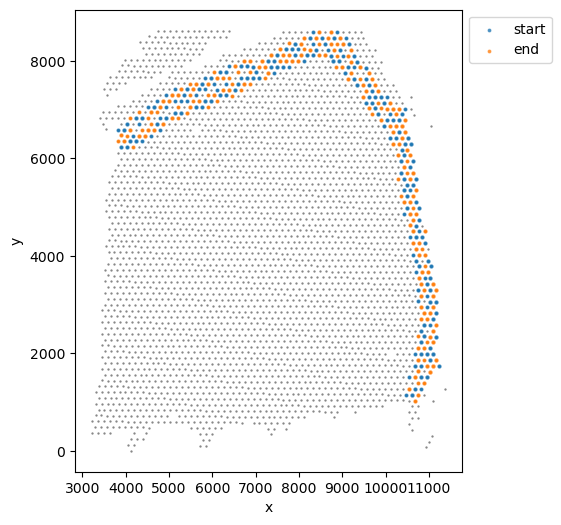

In [148]:
fig, ax = plt.subplots(figsize=(5,6))
ax.scatter(loc_df['x'], loc_df['y'], c= "grey", s=0.4)
sns.scatterplot(data = start_nodes, x = "x", y = "y", s = 8, ax=ax, alpha=0.8,label='start')
sns.scatterplot(data = end_nodes, x = "x", y = "y", s = 8, ax=ax, alpha=0.8,label='end')
#plt.axis('off')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [134]:
type_1_pos

,interaction,x,y
cell,,,
AAACTCGTGATATAAG-1,Layer_2=Layer_3,10431,5822
AAACTCGTGATATAAG-1,Layer_2=Layer_3,10431,5822
AAACTCGTGATATAAG-1,Layer_2=Layer_3,10431,5822
AAACTCGTGATATAAG-1,Layer_3=Layer_2,10431,5822
AAACTCGTGATATAAG-1,Layer_3=Layer_2,10431,5822
...,...,...,...
TCCCAAAGCCCTAAAT-1,Layer_2=Layer_3,10692,3903
TCTGATCGGGTGCTAG-1,Layer_2=Layer_3,10766,4502
TCTGATCGGGTGCTAG-1,Layer_3=Layer_2,10766,4502


In [130]:
type_2_pos = int_loc_df.loc[list(set(type_2_pos.index.values).difference(set(type_1_pos.index.values))),]

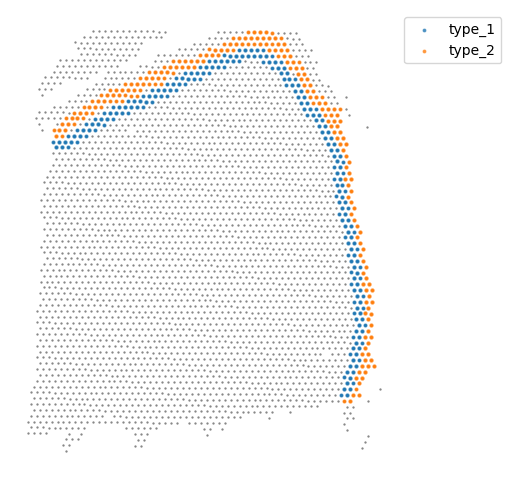

In [137]:
fig, ax = plt.subplots(figsize=(5,6))
ax.scatter(loc_df['x'], loc_df['y'], c= "grey", s=0.4)
sns.scatterplot(data = type_1_pos, x = "x", y = "y", s = 8, ax=ax, alpha=0.8,label='type_1')
sns.scatterplot(data = type_2_pos, x = "x", y = "y", s = 8, ax=ax, alpha=0.8,label='type_2')
plt.axis('off')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [112]:
print(G2)

Graph with 417 nodes and 997 edges


In [111]:
int_loc_df.reset_index().drop_duplicates('cell')

,cell,interaction,x,y
0,AACATCGATACGTCTA-1,Layer_2=Layer_2,10437,6541
8,AGGCGTCTATGGACGG-1,Layer_2=Layer_2,10369,6661
18,CCGAGCTGTGCTTGTC-1,Layer_2=Layer_2,10367,6422
26,CCGTATTAGCGCAGTT-1,Layer_2=Layer_2,10299,6542
34,GCCTATGCTGGGCCTT-1,Layer_2=Layer_2,10505,6421
...,...,...,...,...
1770,TCCAGATGTACGCCAA-1,Layer_2=Layer_3,10499,5702
1772,TCCCAAAGCCCTAAAT-1,Layer_3=Layer_2,10692,3903
1776,TCTGATCGGGTGCTAG-1,Layer_2=Layer_3,10766,4502
1778,TTCTTCGCAATAGAGC-1,Layer_2=Layer_1,8523,8472


In [ ]:
# Calculate pairwise distance and the displacement should be lower than the min distance
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances


In [106]:
independent_edges = nx.maximum_independent_edge_set(G2)

AttributeError: module 'networkx' has no attribute 'maximum_independent_edge_set'

### Custom libraries